# Visualize seed perturbation

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy.stats import pearsonr
from glob import glob

from config import PIPELINE_RUN_DIR, AMIMS, NETWORKS, SEED_SETS
from functions import split_module_id, load_merged_stats, save_figure
prefix = "06"

In [2]:
summary_path = os.path.join(PIPELINE_RUN_DIR, "main/results/mqc_summaries/seed_permutation_mqc.tsv")
detail_paths = glob(os.path.join(PIPELINE_RUN_DIR, "main/results/evaluation/seed_permutation/*/*detailed.tsv"))

In [3]:
amim_meta_df = pd.DataFrame.from_dict(AMIMS)
network_meta_df = pd.DataFrame.from_dict(NETWORKS)
seed_meta_df = pd.DataFrame.from_dict(SEED_SETS)

# drop "no_tool" from the amim meta df
amim_meta_df = amim_meta_df[amim_meta_df.id != "no_tool"]

# summaries per module
summary_df = pd.read_csv(summary_path, sep="\t")
summary_df[["seed_id","network_id","amim_id"]] = summary_df.id.apply(split_module_id)
summary_df["network"] = summary_df["network_id"].replace(dict(zip(network_meta_df.id, network_meta_df.label)))
summary_df["amim"] = summary_df["amim_id"].replace(dict(zip(amim_meta_df.id, amim_meta_df.label)))

# gene-level information
detail_df_list = []
for path in detail_paths:
    module_id = os.path.basename(os.path.dirname(path))     # directory name is the module id
    df = pd.read_csv(path, sep="\t")
    df[["seed_id","network_id","amim_id"]] = split_module_id(module_id)
    detail_df_list.append(df)
detail_df = pd.concat(detail_df_list, ignore_index=True)
detail_df_list = None
detail_df["network"] = detail_df["network_id"].replace(dict(zip(network_meta_df.id, network_meta_df.label)))
detail_df["amim"] = detail_df["amim_id"].replace(dict(zip(amim_meta_df.id, amim_meta_df.label)))

merged_df = summary_df.merge(load_merged_stats(),on=["seed_id", "network_id", "network", "amim_id", "amim"], how="left")
# drop nans for empty modules
merged_df = merged_df.dropna(subset=["avg_jaccard_index"])


## Summary visualizations

### Robustness

In [13]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=summary_df, y="avg_jaccard_index", hue="amim", x="amim", fill=False, palette=dict(zip(amim_meta_df.label, amim_meta_df.color)), order=amim_meta_df.label)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Mean Jaccard similarity")
plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_robustness")
plt.show()


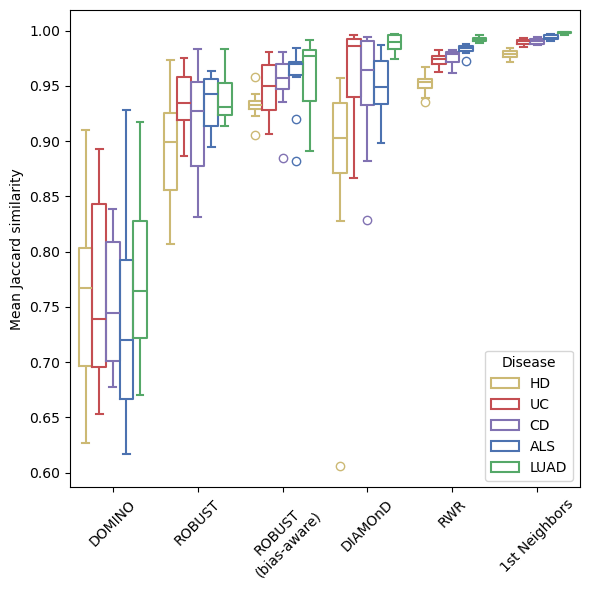

In [34]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=summary_df, y="avg_jaccard_index", hue="seed_id", x="amim", fill=False, palette=dict(zip(seed_meta_df.short, seed_meta_df.color)), order=amim_meta_df.label, hue_order=seed_meta_df.short)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Mean Jaccard similarity")
plt.legend(title="Disease")
plt.tight_layout()
plt.show()

In [35]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=summary_df, y="avg_jaccard_index", hue="network", x="amim", fill=False, palette=dict(zip(network_meta_df.label, network_meta_df.color)), order=amim_meta_df.label, hue_order=network_meta_df.label)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Mean Jaccard similarity")
plt.legend(title="Network")
plt.tight_layout()
plt.show()

In [20]:
# Create the lmplot
g = sns.lmplot(
    data=merged_df,
    x="Seeds_seeds",
    y="avg_jaccard_index",
    col="amim",       # One facet per 'amim' level
    col_order=amim_meta_df.label,
    hue="amim",
    hue_order=amim_meta_df.label,
    palette=dict(zip(amim_meta_df.label, amim_meta_df.color)),
    legend=True,
    height=3.5,
    aspect=4/7,
    scatter_kws={"s": 40, "alpha": 0.7},
    line_kws={"linewidth": 2},
    facet_kws={"sharex": False,},
)

# Custom annotation function
def annotate_corr(data, **kwargs):
    r, p = pearsonr(data["Seeds_seeds"], data["avg_jaccard_index"])
    ax = plt.gca()
    ax.text(
        0.05, 0.05,
        f"r = {r:.2f}\np = {p:.3g}",
        transform=ax.transAxes,
        verticalalignment="bottom",
        horizontalalignment="left",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.5)
    )

# Apply the annotation function to each facet
g.map_dataframe(annotate_corr)

g.set_axis_labels("Number of seeds", "Mean Jaccard similarity")
g.set_titles("{col_name}")  # removes facet titles

plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_robustness_vs_seeds")
plt.show()

In [ ]:
# Create the lmplot
g = sns.lmplot(
    data=merged_df,
    x="edges_network",
    y="avg_jaccard_index",
    col="amim",       # One facet per 'amim' level
    col_order=amim_meta_df.label,
    hue="amim",
    hue_order=amim_meta_df.label,
    palette=dict(zip(amim_meta_df.label, amim_meta_df.color)),
    legend=True,
    height=3.5,
    aspect=4/7,
    scatter_kws={"s": 40, "alpha": 0.7},
    line_kws={"linewidth": 2},
    facet_kws={"sharex": False,},
)

# Custom annotation function
def annotate_corr(data, **kwargs):
    r, p = pearsonr(data["edges_network"], data["avg_jaccard_index"])
    ax = plt.gca()
    ax.text(
        0.05, 0.05,
        f"r = {r:.2f}\np = {p:.3g}",
        transform=ax.transAxes,
        verticalalignment="bottom",
        horizontalalignment="left",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8)
    )

# Apply the annotation function to each facet
g.map_dataframe(annotate_corr)

g.set_axis_labels("Number of network edges", "Mean Jaccard similarity")
g.set_titles("{col_name}") 

# increase distance between x axis and x axis label
for ax in g.axes.flatten():
    ax.xaxis.labelpad = 20


plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_robustness_vs_network_edges")
plt.show()

In [41]:
# Create the lmplot
g = sns.lmplot(
    data=merged_df,
    x="nodes_module",
    y="avg_jaccard_index",
    col="amim",       # One facet per 'amim' level
    col_order=amim_meta_df.label,
    hue="amim",
    hue_order=amim_meta_df.label,
    palette=dict(zip(amim_meta_df.label, amim_meta_df.color)),
    legend=True,
    height=3.5,
    aspect=4/7,
    scatter_kws={"s": 40, "alpha": 0.7},
    line_kws={"linewidth": 2},
    facet_kws={"sharex": False,},
)

# Custom annotation function
def annotate_corr(data, **kwargs):
    r, p = pearsonr(data["nodes_module"], data["avg_jaccard_index"])
    ax = plt.gca()
    ax.text(
        0.05, 0.05,
        f"r = {r:.2f}\np = {p:.3g}",
        transform=ax.transAxes,
        verticalalignment="bottom",
        horizontalalignment="left",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8)
    )

# Apply the annotation function to each facet
g.map_dataframe(annotate_corr)

g.set_axis_labels("Number of module nodes", "Mean Jaccard similarity")
g.set_titles("{col_name}")  # removes facet titles

plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_robustness_vs_module_nodes")
plt.show()

In [12]:

# Set up the figure
fig, ax = plt.subplots(figsize=(6, 4))

# Plot using regplot
sns.regplot(
    data=merged_df,
    x="nodes_module",
    y="avg_jaccard_index",
    scatter_kws={"s": 40, "alpha": 0.7},
    line_kws={"linewidth": 2},
    ax=ax,
    logx=True,
)

# Set x-axis to log scale
ax.set_xscale('log')

# Annotate Pearson correlation
r, p = pearsonr(np.log10(merged_df["nodes_module"]), merged_df["avg_jaccard_index"])
ax.text(
    0.8, 0.05,
    f"r = {r:.2f}\np = {p:.3g}",
    transform=ax.transAxes,
    verticalalignment="bottom",
    horizontalalignment="left",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8)
)

# Axis labels
ax.set_xlabel("Number of module nodes")
ax.set_ylabel("Mean Jaccard similarity")
ax.set_ylim(top=1)


plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_robustness_vs_module_nodes_combined")
plt.show()

### Seed rediscovery rate

In [18]:
plt.figure(figsize=(4, 4))
sns.boxplot(data=summary_df, y="rediscovery_rate", hue="amim", x="amim", fill=False, palette=dict(zip(amim_meta_df.label, amim_meta_df.color)), order=amim_meta_df.label)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Rediscovery rate")
plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_rediscovery_rate")
plt.show()

plt.figure(figsize=(4, 4))
sns.boxplot(data=summary_df, y="normalized_rediscovery_rate", hue="amim", x="amim", fill=False, palette=dict(zip(amim_meta_df.label, amim_meta_df.color)), order=amim_meta_df.label)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Normalized rediscovery rate")
plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_normalized_rediscovery_rate")
plt.show()

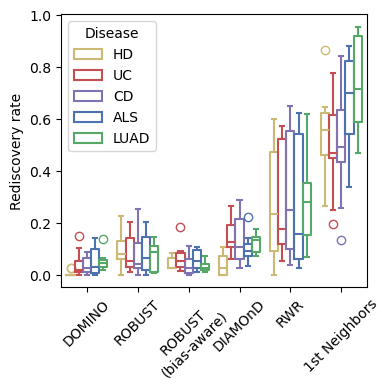

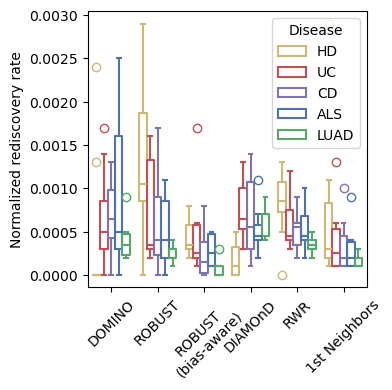

In [17]:
plt.figure(figsize=(4, 4))
sns.boxplot(data=summary_df, y="rediscovery_rate", hue="seed_id", x="amim", fill=False, palette=dict(zip(seed_meta_df.short, seed_meta_df.color)), order=amim_meta_df.label, hue_order=seed_meta_df.short)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Rediscovery rate")
plt.legend(title="Disease")
plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_rediscovery_rate_by_disease")
plt.show()

plt.figure(figsize=(4, 4))
sns.boxplot(data=summary_df, y="normalized_rediscovery_rate", hue="seed_id", x="amim", fill=False, palette=dict(zip(seed_meta_df.short, seed_meta_df.color)), order=amim_meta_df.label, hue_order=seed_meta_df.short)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Normalized rediscovery rate")
plt.legend(title="Disease")
plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_normalized_rediscovery_rate_by_disease")
plt.show()

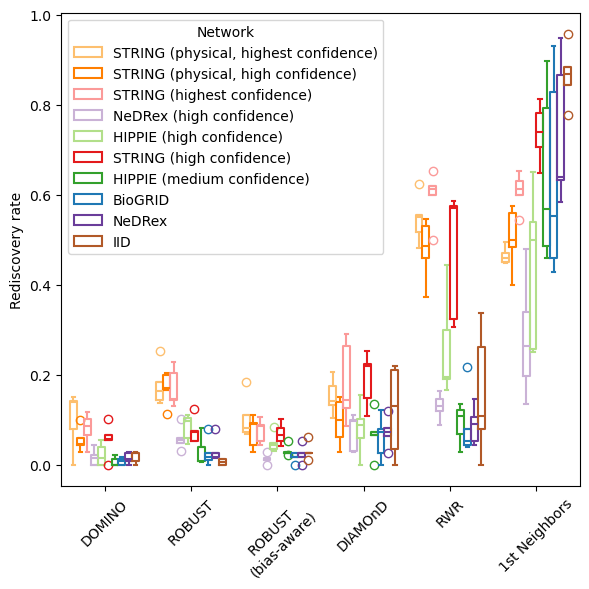

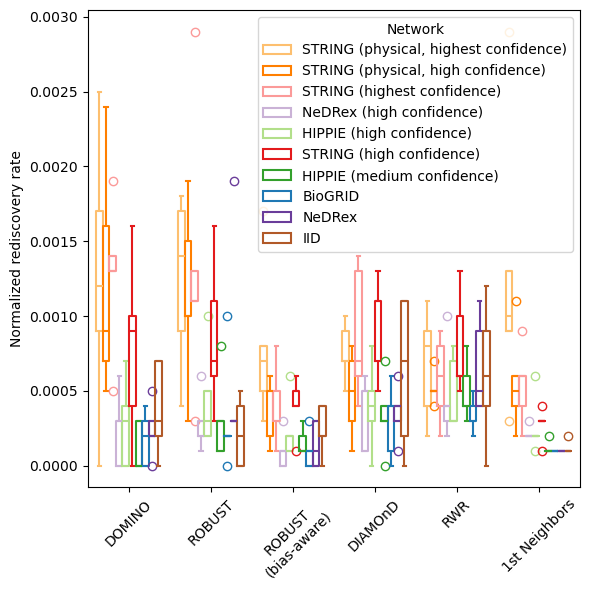

In [42]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=summary_df, y="rediscovery_rate", hue="network", x="amim", fill=False, palette=dict(zip(network_meta_df.label, network_meta_df.color)), order=amim_meta_df.label, hue_order=network_meta_df.label)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Rediscovery rate")
plt.legend(title="Network")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
sns.boxplot(data=summary_df, y="normalized_rediscovery_rate", hue="network", x="amim", fill=False, palette=dict(zip(network_meta_df.label, network_meta_df.color)), order=amim_meta_df.label, hue_order=network_meta_df.label)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Normalized rediscovery rate")
plt.legend(title="Network")
plt.tight_layout()
plt.show()

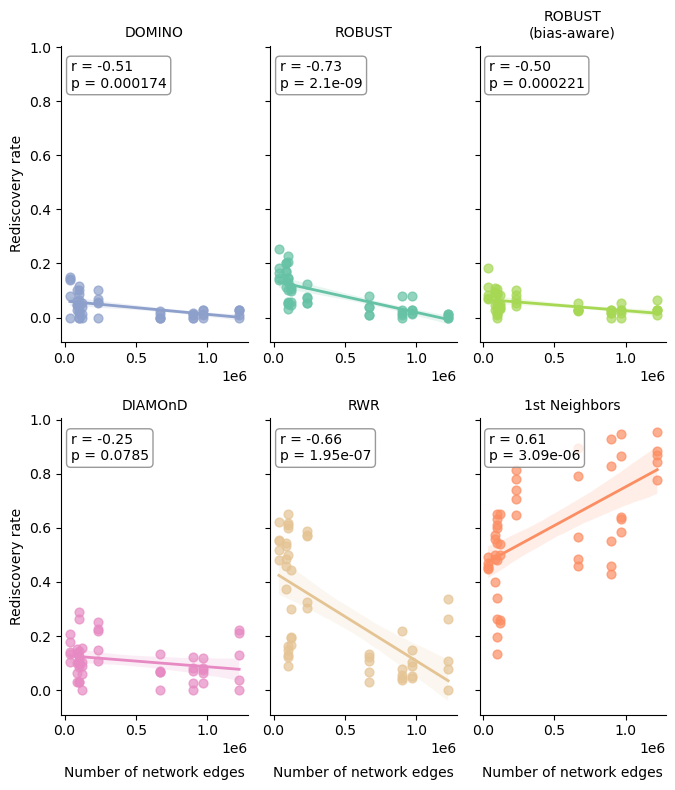

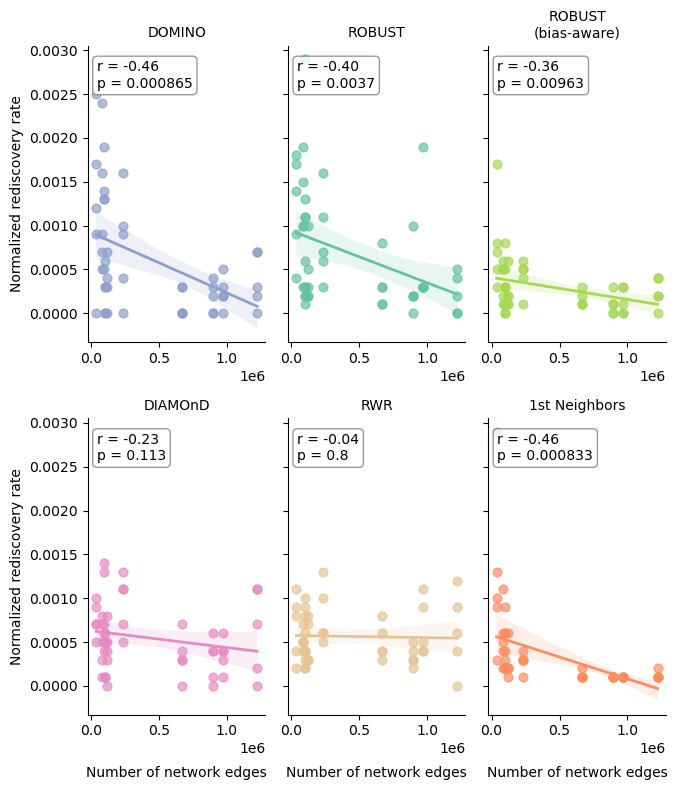

In [25]:
# Create the lmplot
g = sns.lmplot(
    data=merged_df,
    x="edges_network",
    y="rediscovery_rate",
    col="amim",       # One facet per 'amim' level
    col_order=amim_meta_df.label,
    hue="amim",
    hue_order=amim_meta_df.label,
    palette=dict(zip(amim_meta_df.label, amim_meta_df.color)),
    legend=True,
    height=4,
    aspect=4/7,
    scatter_kws={"s": 40, "alpha": 0.7},
    line_kws={"linewidth": 2},
    facet_kws={"sharex": False,},
    col_wrap=3,
)

# Custom annotation function
def annotate_corr(data, **kwargs):
    r, p = pearsonr(data["edges_network"], data["rediscovery_rate"])
    ax = plt.gca()
    ax.text(
        0.05, 0.95,
        f"r = {r:.2f}\np = {p:.3g}",
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="left",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8)
    )

# Apply the annotation function to each facet
g.map_dataframe(annotate_corr)

g.set_axis_labels("Number of network edges", "Rediscovery rate")
g.set_titles("{col_name}")  # removes facet titles

# increase distance between x axis and x axis label
for ax in g.axes.flatten():
    ax.xaxis.labelpad = 20

plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_rediscovery_rate_vs_network_edges")
plt.show()

# Create the lmplot
g = sns.lmplot(
    data=merged_df,
    x="edges_network",
    y="normalized_rediscovery_rate",
    col="amim",       # One facet per 'amim' level
    col_order=amim_meta_df.label,
    hue="amim",
    hue_order=amim_meta_df.label,
    palette=dict(zip(amim_meta_df.label, amim_meta_df.color)),
    legend=True,
    height=4,
    aspect=4/7,
    scatter_kws={"s": 40, "alpha": 0.7},
    line_kws={"linewidth": 2},
    facet_kws={"sharex": False,},
    col_wrap=3,
)

# Custom annotation function
def annotate_corr(data, **kwargs):
    r, p = pearsonr(data["edges_network"], data["normalized_rediscovery_rate"])
    ax = plt.gca()
    ax.text(
        0.05, 0.95,
        f"r = {r:.2f}\np = {p:.3g}",
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="left",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8)
    )

# Apply the annotation function to each facet
g.map_dataframe(annotate_corr)

g.set_axis_labels("Number of network edges", "Normalized rediscovery rate")
g.set_titles("{col_name}")  # removes facet titles

# increase distance between x axis and x axis label
for ax in g.axes.flatten():
    ax.xaxis.labelpad = 20

plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_normalized_rediscovery_rate_vs_network_edges")
plt.show()

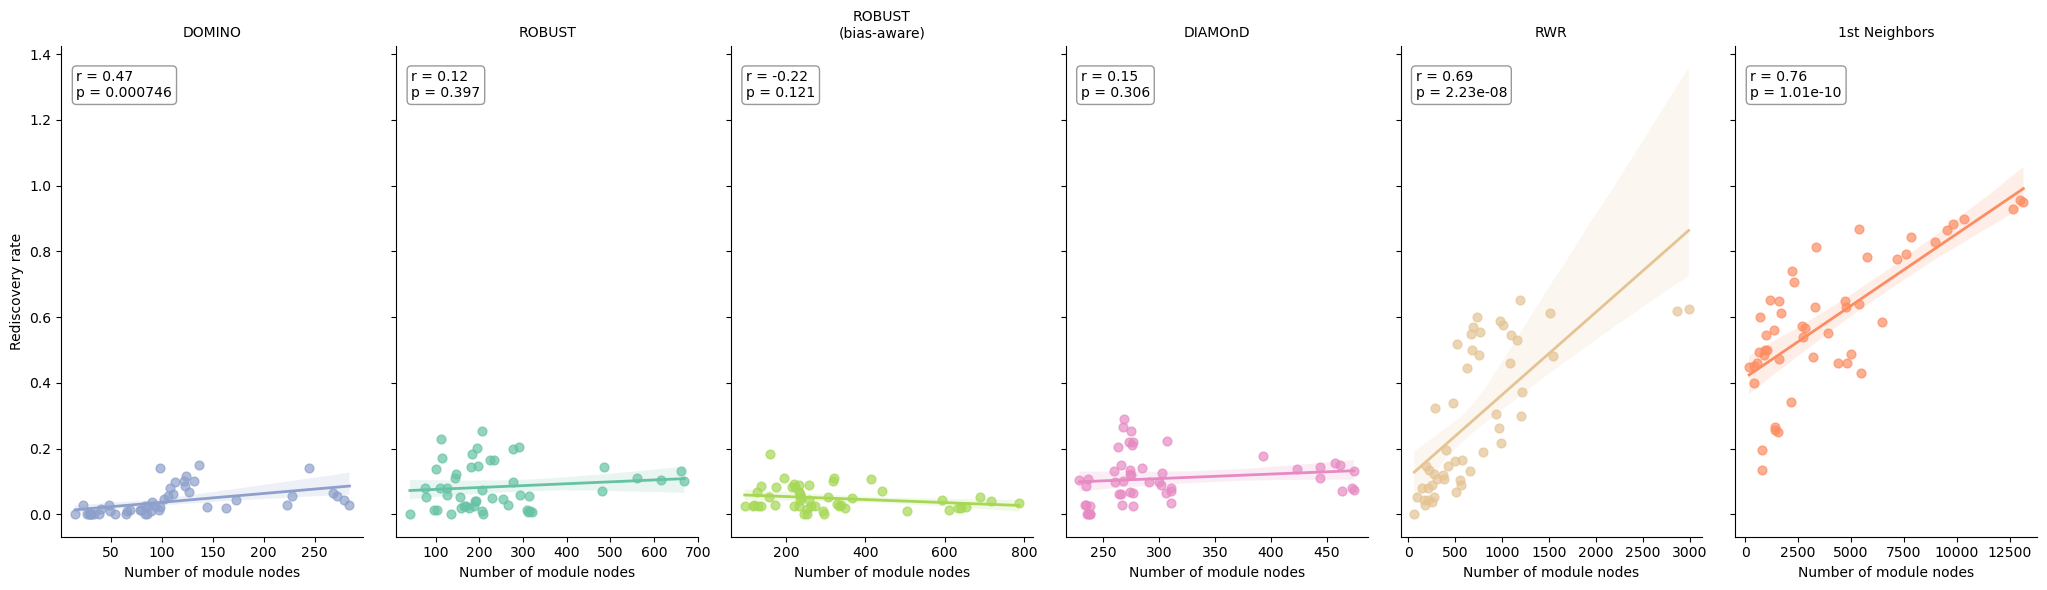

In [44]:
# Create the lmplot
g = sns.lmplot(
    data=merged_df,
    x="nodes_module",
    y="rediscovery_rate",
    col="amim",       # One facet per 'amim' level
    col_order=amim_meta_df.label,
    hue="amim",
    hue_order=amim_meta_df.label,
    palette=dict(zip(amim_meta_df.label, amim_meta_df.color)),
    legend=True,
    height=6,
    aspect=4/7,
    scatter_kws={"s": 40, "alpha": 0.7},
    line_kws={"linewidth": 2},
    facet_kws={"sharex": False,},
)

# Custom annotation function
def annotate_corr(data, **kwargs):
    r, p = pearsonr(data["nodes_module"], data["rediscovery_rate"])
    ax = plt.gca()
    ax.text(
        0.05, 0.95,
        f"r = {r:.2f}\np = {p:.3g}",
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="left",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8)
    )

# Apply the annotation function to each facet
g.map_dataframe(annotate_corr)

g.set_axis_labels("Number of module nodes", "Rediscovery rate")
g.set_titles("{col_name}")  # removes facet titles

plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_rediscovery_rate_vs_module_nodes")
plt.show()

# Create the lmplot
g = sns.lmplot(
    data=merged_df,
    x="nodes_module",
    y="normalized_rediscovery_rate",
    col="amim",       # One facet per 'amim' level
    col_order=amim_meta_df.label,
    hue="amim",
    hue_order=amim_meta_df.label,
    palette=dict(zip(amim_meta_df.label, amim_meta_df.color)),
    legend=True,
    height=6,
    aspect=4/7,
    scatter_kws={"s": 40, "alpha": 0.7},
    line_kws={"linewidth": 2},
    facet_kws={"sharex": False,},
)

# Custom annotation function
def annotate_corr(data, **kwargs):
    r, p = pearsonr(data["nodes_module"], data["normalized_rediscovery_rate"])
    ax = plt.gca()
    ax.text(
        0.05, 0.95,
        f"r = {r:.2f}\np = {p:.3g}",
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="left",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8)
    )

# Apply the annotation function to each facet
g.map_dataframe(annotate_corr)

g.set_axis_labels("Number of module nodes", "Normalized rediscovery rate")
g.set_titles("{col_name}")  # removes facet titles

plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_normalized_rediscovery_rate_vs_module_nodes")
plt.show()

## Gene-level visualization

### Seed rediscovery rate

In [45]:
def plot_dynamic_heatmap(data, row_height=0.2, col_width=1, annot=True, title="",  cbar=False, yticklabels=True, **kwargs):
    """
    Plot a heatmap with dynamic figure size based on data shape
    
    Parameters:
        data (DataFrame or 2D array): Heatmap data.
        row_height (float): Height per row in inches.
        col_width (float): Width per column in inches.
        kwargs: Other keyword arguments passed to sns.heatmap.
    """

        # Start with the Reds colormap
    reds = plt.get_cmap("Reds")

    # Create a new colormap that maps 0 to white
    new_colors = reds(np.linspace(0, 1, 256))
    new_colors[0] = [1, 1, 1, 1]  # RGBA for white

    # Create the new colormap
    white_to_reds = mcolors.ListedColormap(new_colors)

    n_rows, n_cols = data.shape
    height = max(2, n_rows * row_height)
    width = max(2, n_cols * col_width)

    plt.figure(figsize=(width, height))
    ax = sns.heatmap(
        data,
        linecolor="black",
        linewidths=0.5, 
        cmap=white_to_reds, 
        annot=annot, 
        yticklabels=yticklabels, 
        cbar=cbar, 
        **kwargs)
    ax.tick_params(labeltop=True, labelbottom=True)
    ax.set_title(title)
    ax.set_xlabel("")
    plt.tight_layout()
    return ax


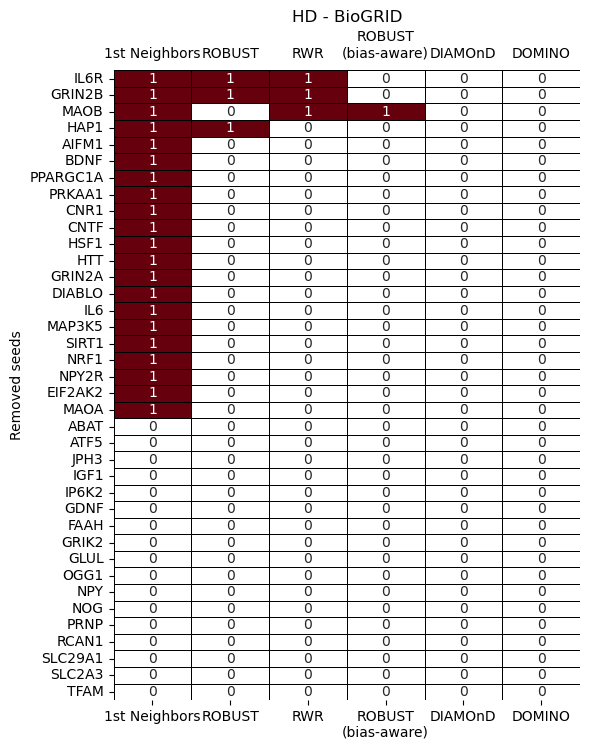

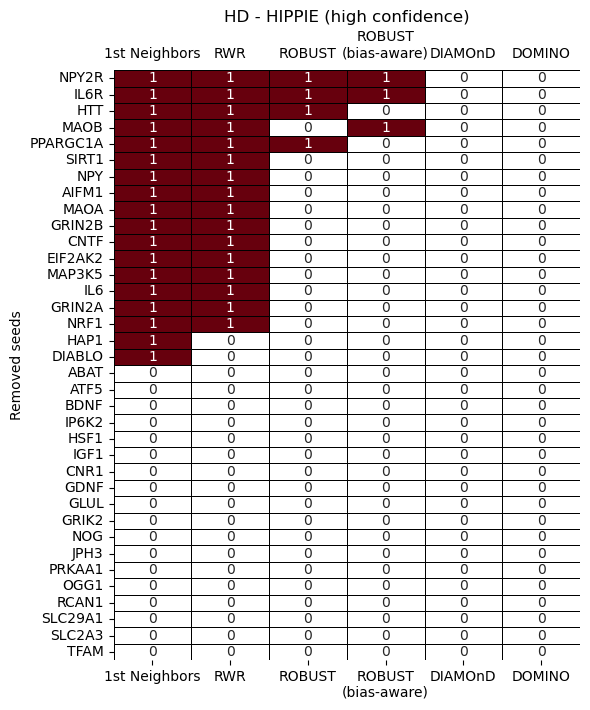

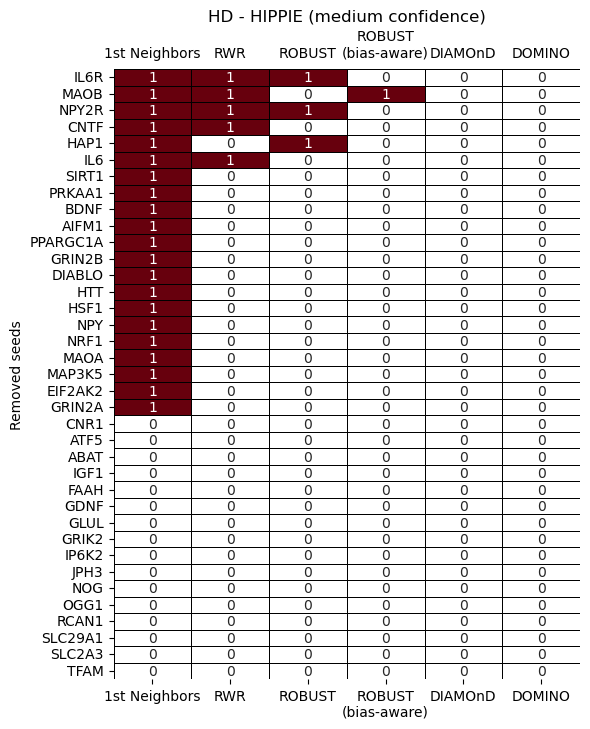

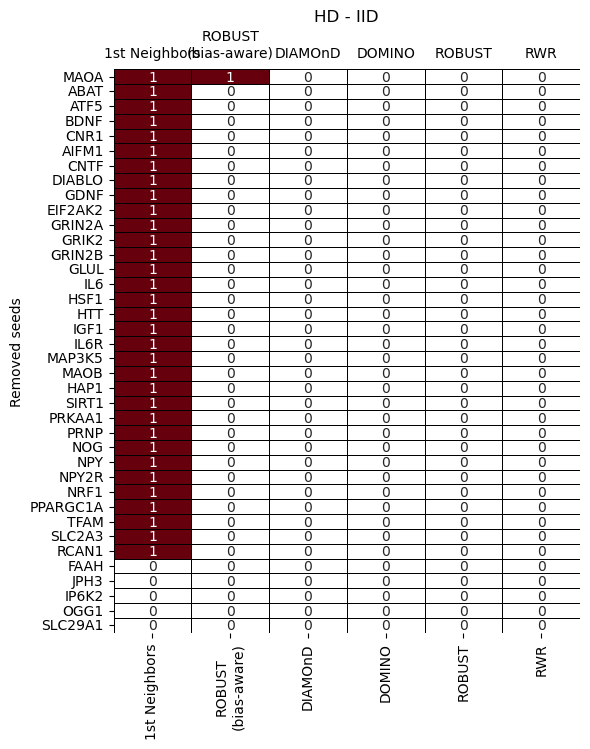

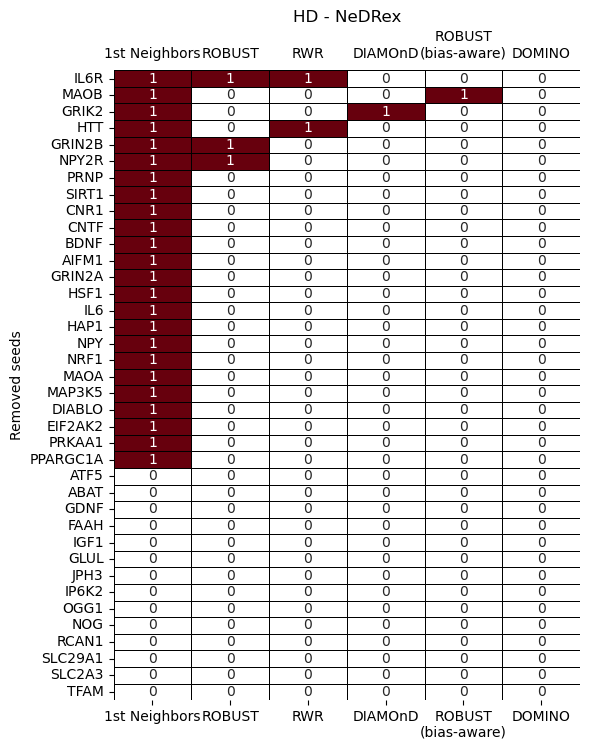

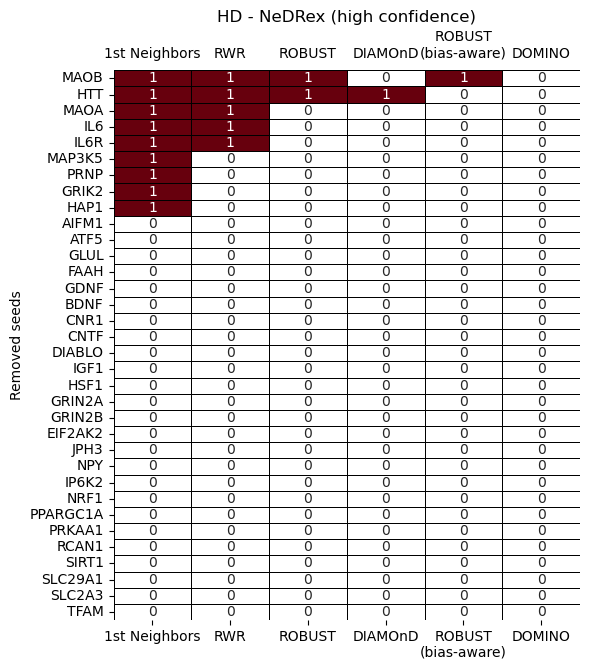

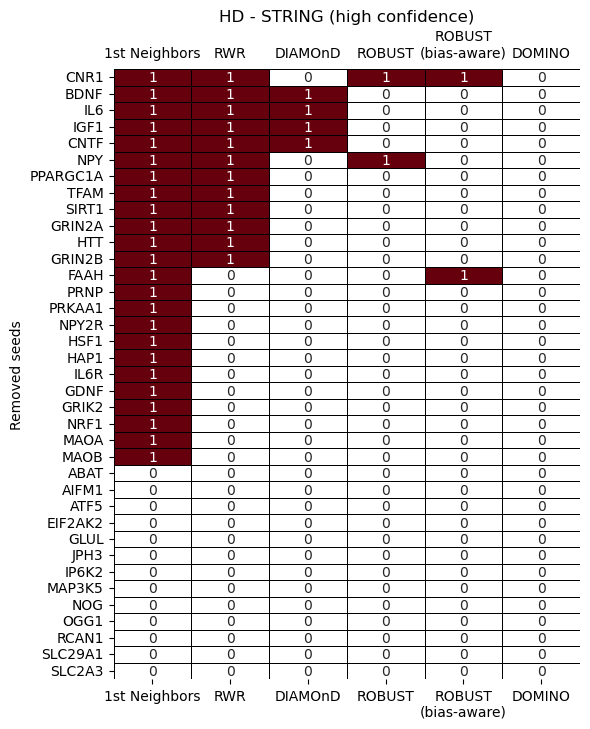

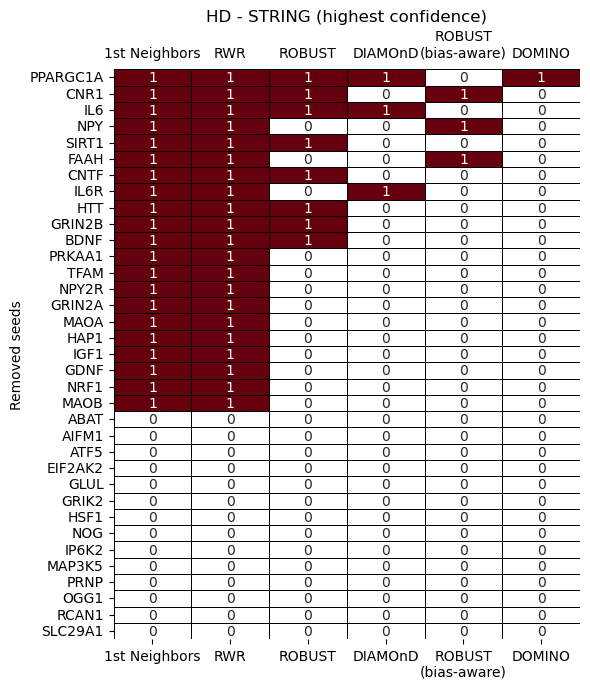

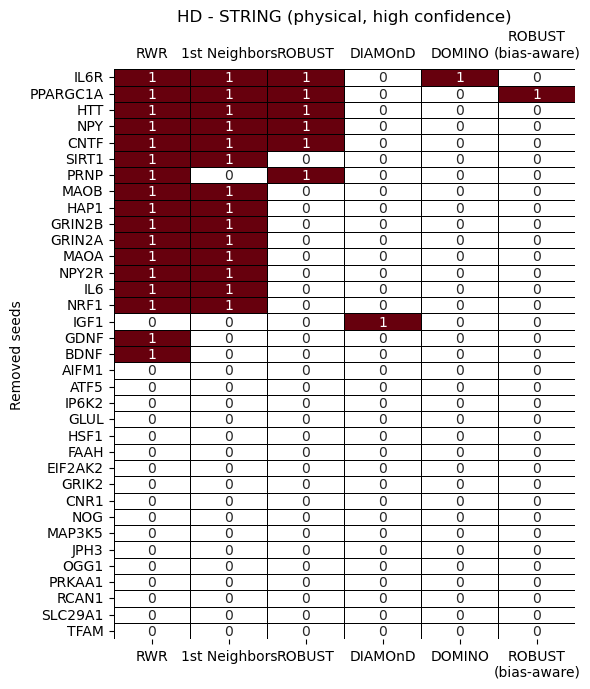

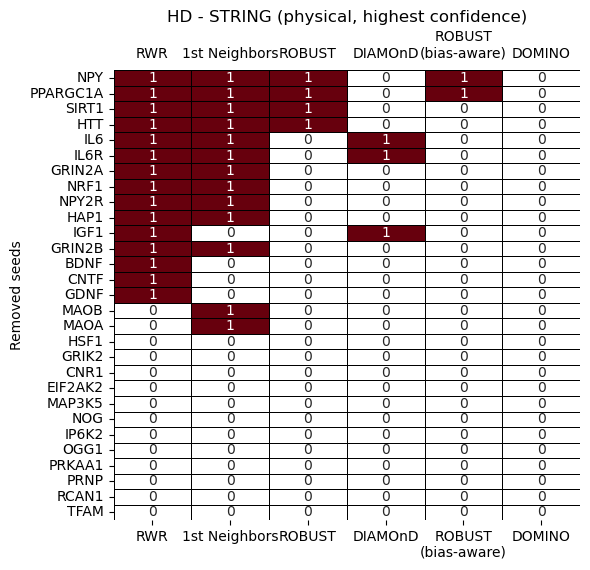

In [46]:
grouped_dfs = [(group, data) for group, data in detail_df.groupby(["seed_id","network"])]

# to wide format
for group in grouped_dfs:
    disease = group[0][0]
    network = group[0][1]
    df = group[1]
    if disease != "HD":
        continue
    df = df.pivot(index="Removed seeds", columns="amim", values="Retrieval frequency")
    # sort rows by sum of values
    df = df.loc[df.sum(axis=1).sort_values(ascending=False).index]
    # sort columns by sum of values
    df = df[df.sum(axis=0).sort_values(ascending=False).index]
    title = f"{disease} - {network}"
    # add title to the heatmap
    g = plot_dynamic_heatmap(df, title=title)
    plt.show()

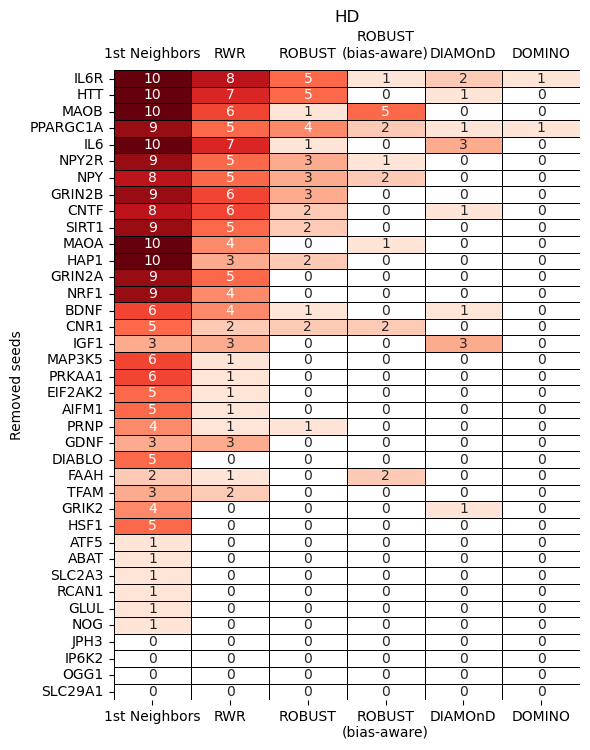

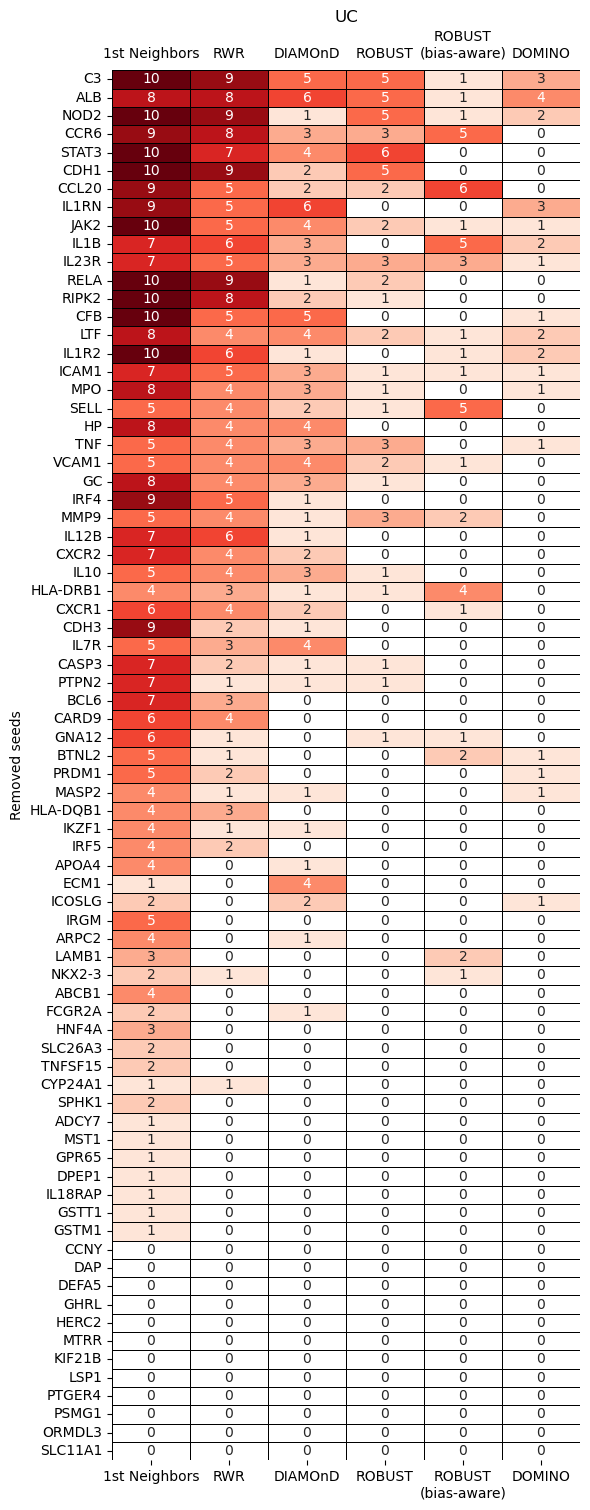

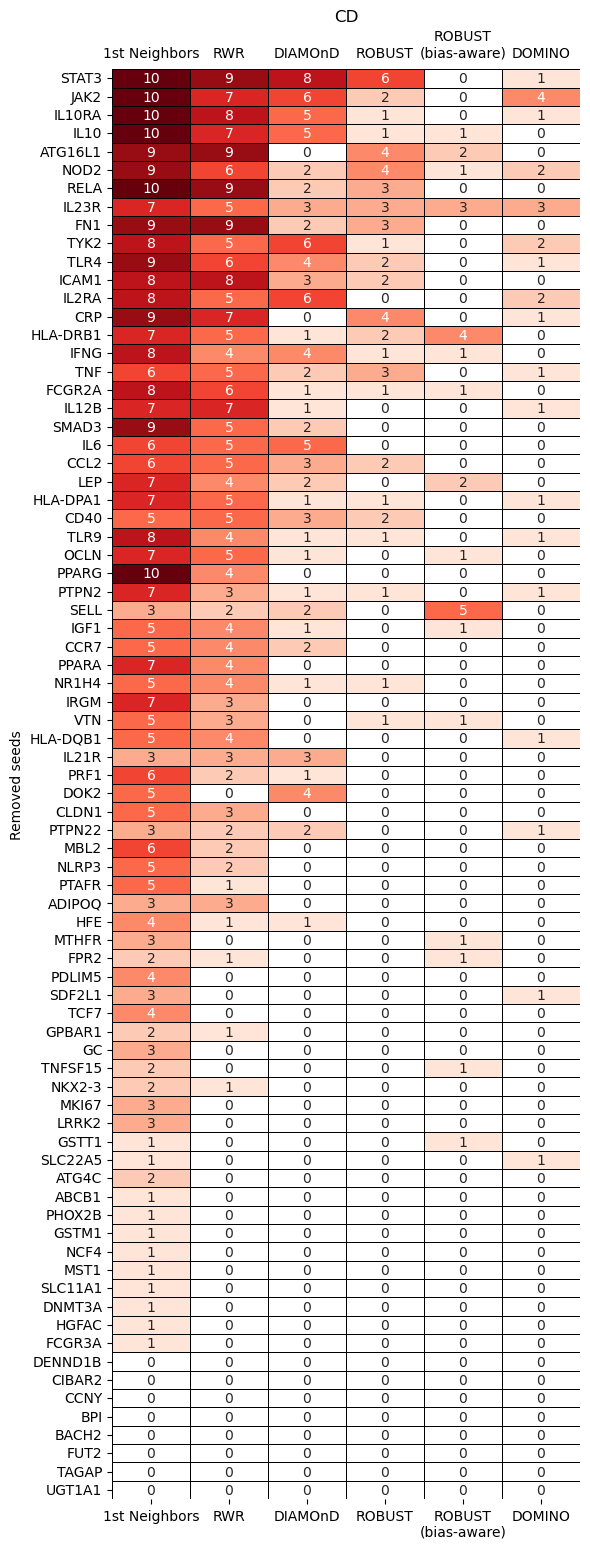

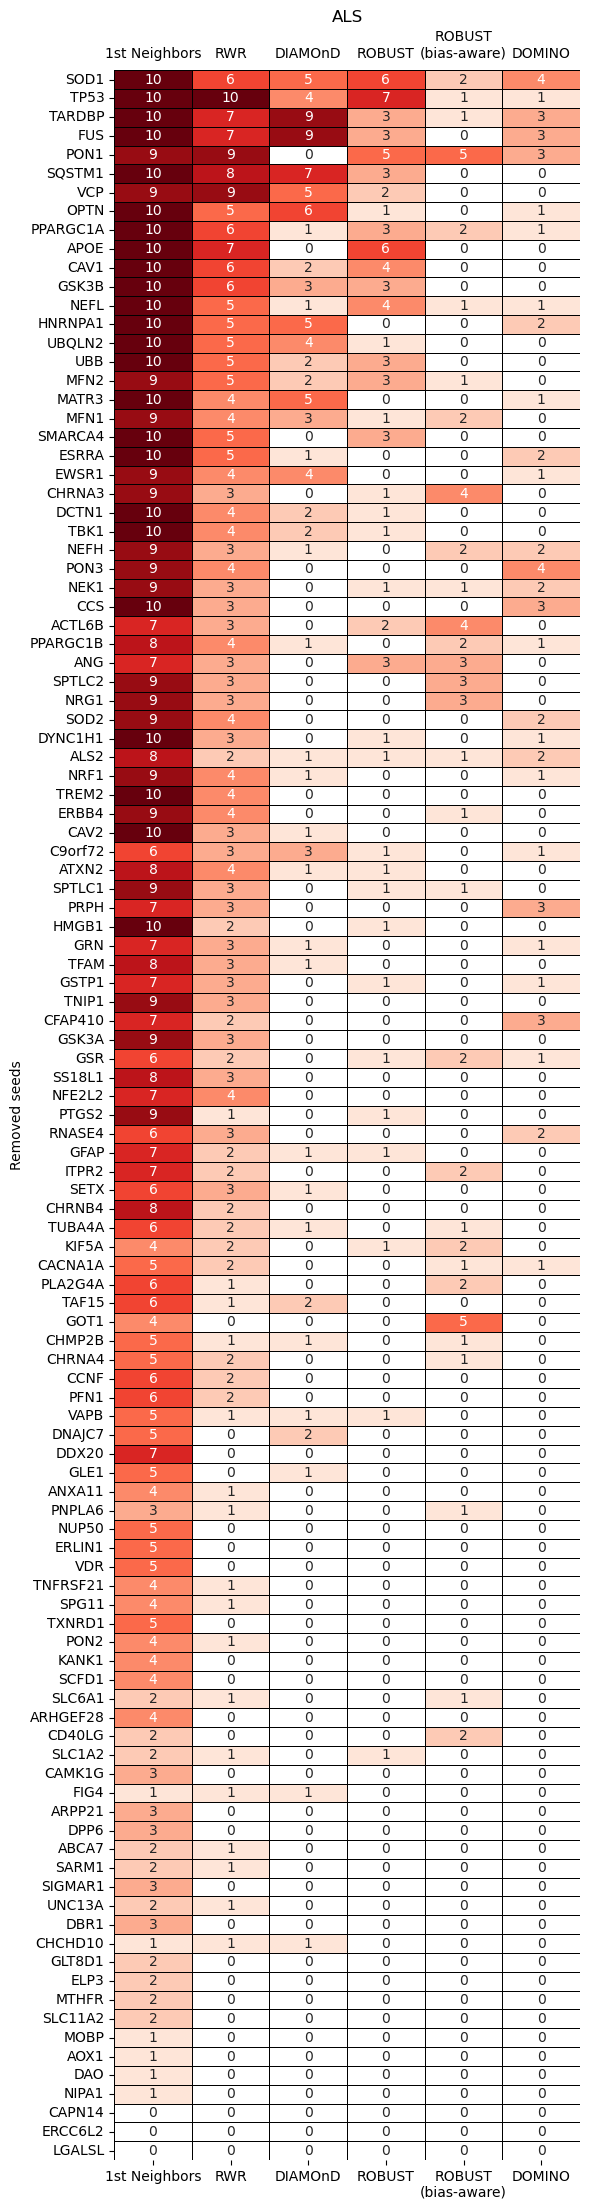

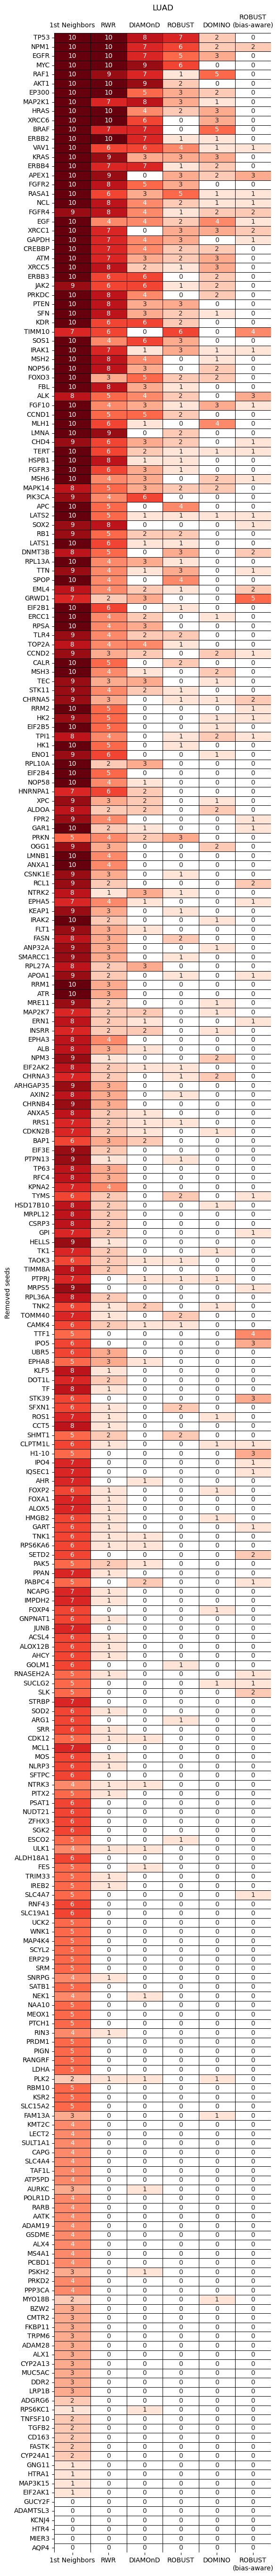

In [47]:
sum_over_networks_df = detail_df.groupby(['seed_id', 'amim', 'Removed seeds'])['Retrieval frequency'].sum().reset_index()

for disease in seed_meta_df.short:
    df = sum_over_networks_df[sum_over_networks_df.seed_id == disease]
    df = df.pivot(index="Removed seeds", columns="amim", values="Retrieval frequency")
    # sort rows by sum of values
    df = df.loc[df.sum(axis=1).sort_values(ascending=False).index]
    # sort columns by sum of values
    df = df[df.sum(axis=0).sort_values(ascending=False).index]
    title = f"{disease}"
    # add title to the heatmap
    g = plot_dynamic_heatmap(df, title=title)
    if disease == "HD":
        save_figure(plt.gcf(), f"{prefix}_gene_retrieval_heatmap_hd")
    plt.show()

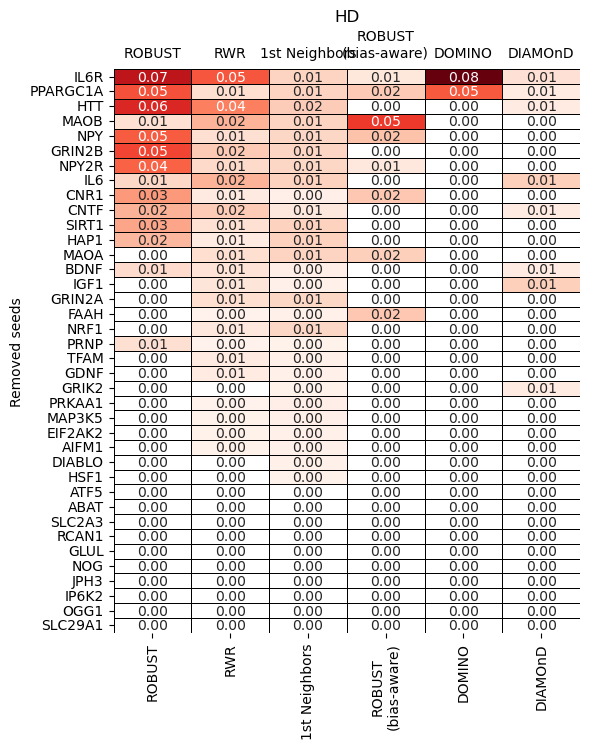

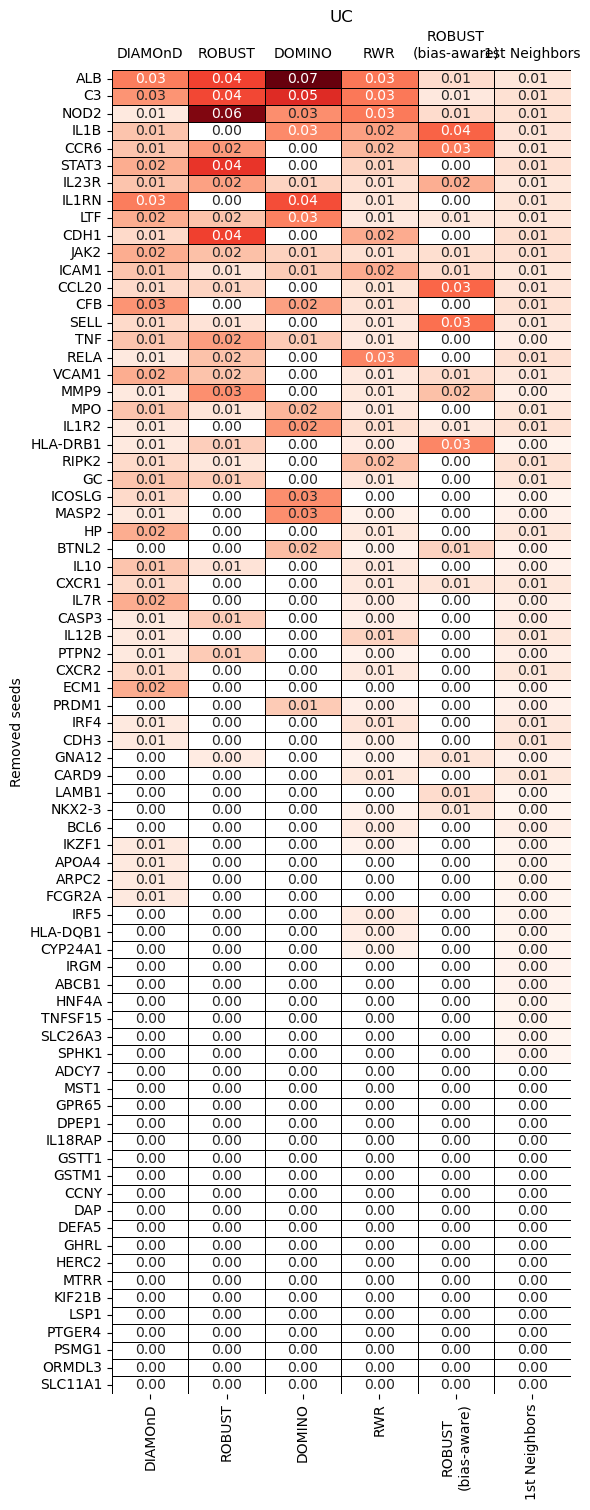

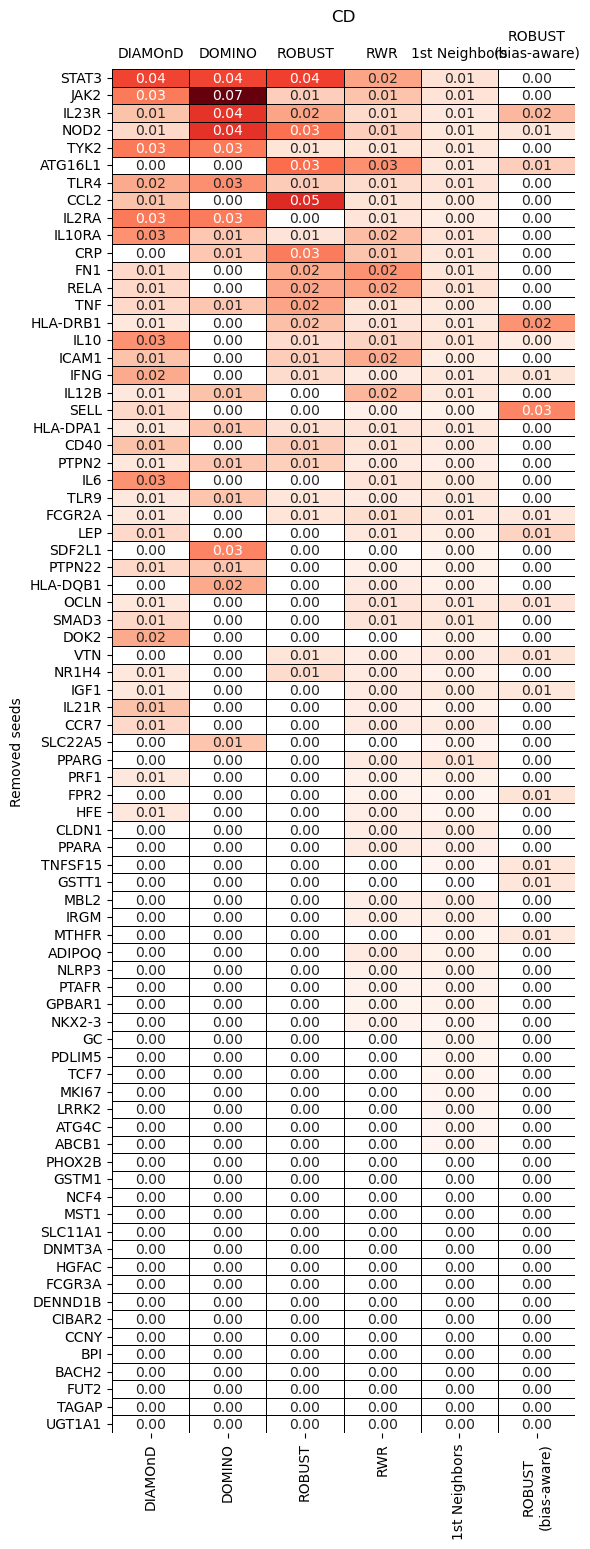

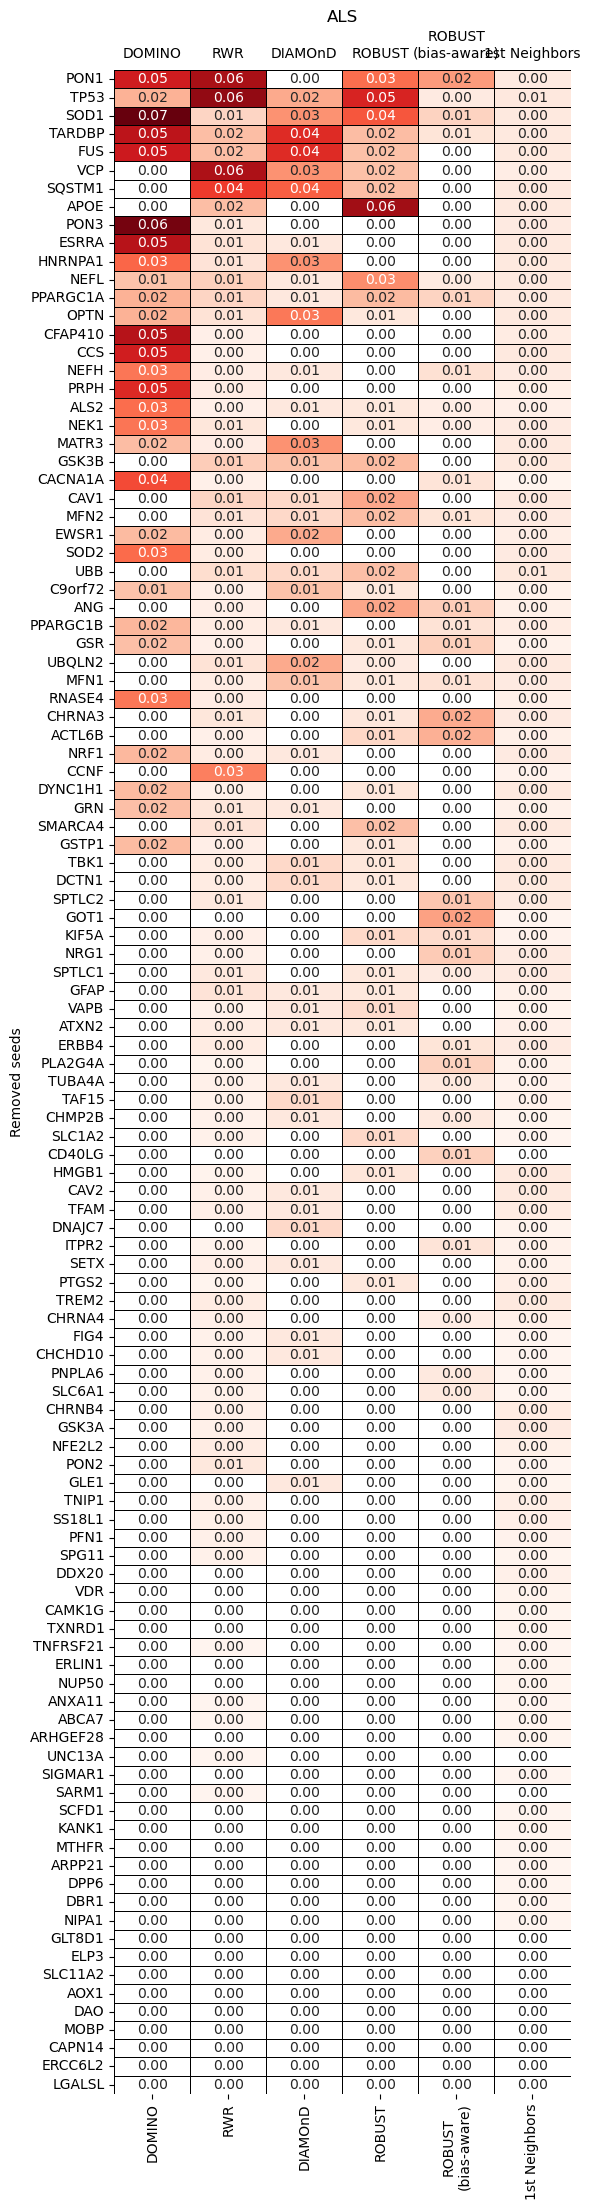

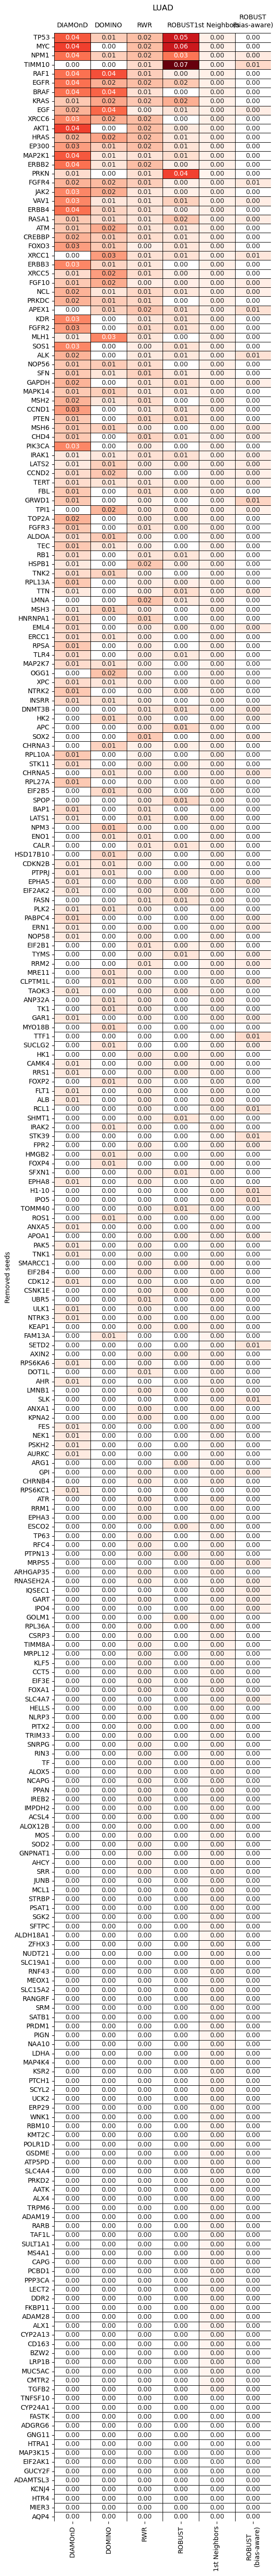

In [48]:
sum_over_networks_df = detail_df.groupby(['seed_id', 'amim', 'Removed seeds'])['Normalized retrieval frequency'].sum().reset_index()

for disease in seed_meta_df.short:
    df = sum_over_networks_df[sum_over_networks_df.seed_id == disease]
    df = df.pivot(index="Removed seeds", columns="amim", values="Normalized retrieval frequency")
    # sort rows by sum of values
    df = df.loc[df.sum(axis=1).sort_values(ascending=False).index]
    # sort columns by sum of values
    df = df[df.sum(axis=0).sort_values(ascending=False).index]
    title = f"{disease}"
    # add title to the heatmap
    g = plot_dynamic_heatmap(df,fmt=".2f",title=title)
    plt.show()